# Convert for CP2K

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from ase.calculators.cp2k import CP2K
from tempfile import TemporaryDirectory
from contextlib import redirect_stderr
from ase.build import molecule
from ase.io import read
from io import StringIO
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
from ase import units

## Get Example Molecules
Let's test on at least Methane

In [2]:
molecules = pd.read_csv('../../data/example_molecules.csv')
print(f'Loaded a total of {len(molecules)} molecules')

Loaded a total of 12 molecules


In [3]:
row = molecules.iloc[2]
atoms = read(StringIO(row['xyz_neutral']), format='xyz').copy()
atoms

Atoms(symbols='C3NOH7', pbc=False)

CP2K requires us to define a cell even for non-periodic systems

In [4]:
def buffer_cell(atoms, buffer_size: float = 3.): 
    """How to buffer the cell such that it has a vacuum layer around the side
    
    Args:
        atoms: Atoms to be centered
        positions: Size of the buffer to place around the atoms
    """

    atoms.positions -= atoms.positions.min(axis=0)
    atoms.cell = [atoms.positions.max() + buffer_size * 2] * 3
    atoms.positions += atoms.cell.max(axis=0) / 2 - atoms.positions.mean(axis=0)
buffer_cell(atoms)

## Evalute the effect of convergence of buffer size and cutoff
We have two

In [5]:
cp2k_opts = dict(
    xc=None,
    inp="""
&FORCE_EVAL
&DFT
  &XC
     &XC_FUNCTIONAL BLYP
     &END XC_FUNCTIONAL
  &END XC
  &MGRID
      NGRIDS 1
  &END MGRID
  &POISSON
     PERIODIC NONE
     PSOLVER WAVELET
  &END POISSON
  &QS
      EXTRAPOLATION USE_GUESS
  &END QS
&END DFT
&END FORCE_EVAL""",
    basis_set_file='GTH_BASIS_SETS',
    basis_set='DZVP-GTH',
    pseudo_potential='GTH-BLYP',
    poisson_solver=None,
)  # Use BLYP as we have PPs for it
calc = CP2K(charge=-1, uks=True, directory='wavelet-conv', **cp2k_opts)

In [6]:
cutoffs = np.arange(200., 800.1, 50.)
print(f'Testing {len(cutoffs)} energies')

Testing 13 energies


Test many cutoff energies

In [7]:
forces = []
energy = []
for cutoff in tqdm(cutoffs):
    calc.set(cutoff=cutoff * units.Ry)
    forces.append(calc.get_forces(atoms))
    energy.append(calc.get_potential_energy(atoms))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [14:36<00:00, 67.41s/it]


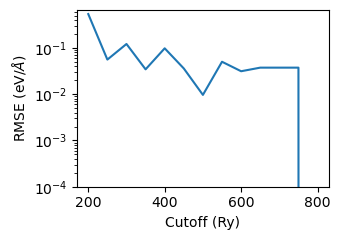

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

rmse = [np.sqrt(np.power(f - forces[-1], 2).mean()) for f in forces]
ax.semilogy(cutoffs, rmse)

ax.set_ylim(1e-4, max(ax.get_ylim()))

ax.set_xlabel('Cutoff (Ry)')
ax.set_ylabel('RMSE (eV/$\\AA$)')
fig.tight_layout()

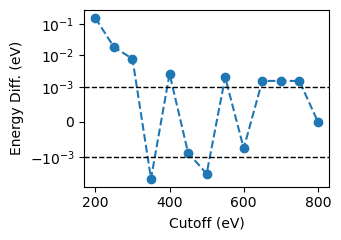

In [9]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(cutoffs, np.subtract(energy, energy[-1]), '--o')

ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [1e-3]*2, 'k--', lw=1)
ax.plot(ax.get_xlim(), [-1e-3]*2, 'k--', lw=1)

ax.set_yscale('symlog', linthresh=1e-3)

ax.set_xlabel('Cutoff (eV)')
ax.set_ylabel('Energy Diff. (eV)')
fig.tight_layout()

We converge at a cutoff of around 400 Ry. The jumps are due to discretization

In [10]:
buffers = np.arange(2., 10.1, 1.)
calc.set(cutoff=400 * units.Ry)

In [11]:
forces = []
energy = []
for b in tqdm(buffers):
    buffer_cell(atoms, buffer_size=b)
    
    forces.append(calc.get_forces(atoms))
    energy.append(calc.get_potential_energy(atoms))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [40:48<00:00, 272.04s/it]


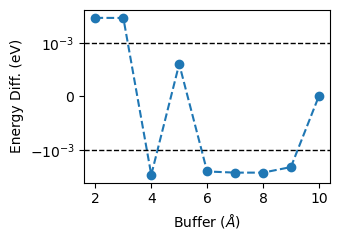

In [12]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(buffers, np.subtract(energy, energy[-1]), '--o')

ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [1e-3]*2, 'k--', lw=1)
ax.plot(ax.get_xlim(), [-1e-3]*2, 'k--', lw=1)

ax.set_yscale('symlog', linthresh=1e-3)

ax.set_xlabel('Buffer ($\\AA$)')
ax.set_ylabel('Energy Diff. (eV)')
fig.tight_layout()

A buffer size of 5 seems safe